In [ ]:
import csv
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import SimpleITK as sitk

%matplotlib inline

In [ ]:
SEED = 42
IMG_DEPTH = 128
DATA_PATH = ".\\data\\"

In [ ]:
import csv


def write_data_file_paths():
    with open(f"{DATA_PATH}\\file_paths.csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["image", "mask", "label"])
        for sbj in range(100):
            if os.path.exists(f"{DATA_PATH}\\0\\{sbj:02}\\CT_partition.npy"):
                label = 0
            elif os.path.exists(f"{DATA_PATH}\\1\\{sbj:02}\\CT_partition.npy"):
                label = 1
            else:
                continue

            writer.writerows(
                [
                    [
                        f"{label}\\{sbj:02}\\CT_partition.npy",
                        f"{label}\\{sbj:02}\\CT_mask.npy",
                        label,
                    ],
                    [
                        f"{label}\\{sbj:02}\\PT_partition.npy",
                        f"{label}\\{sbj:02}\\PT_mask.npy",
                        label,
                    ],
                ]
            )

write_data_file_paths()

### Classical Features

In [ ]:
def load_haralick_features():
    try:
        data = pd.read_csv(f"haralick.csv", index_col=0)
        labels = data.pop("y")
        return data, labels

    except FileNotFoundError:
        print("File not found, generating...")
        data, labels = [], []

        with open(f"{DATA_PATH}\\file_paths.csv", "r") as f:
            reader = csv.reader(f)
            next(reader)
            for image_path, mask_path, label in reader:
                image = np.load(f"{DATA_PATH}\\{image_path}")
                mask = np.load(f"{DATA_PATH}\\{mask_path}")
                ...

## Scikit-Learn

In [6]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

In [7]:
def print_metrics(y_true, y_pred, model_name) -> None:
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(model_name)
    print(f"Sensitivity: {tp / (tp + fn) * 100:.1f}%")
    print(f"Specificity: {tn / (tn + fp) * 100:.1f}%")
    print(f"Accuracy: {accuracy_score(y_true, y_pred) * 100:.1f}%")
    print(f"ROC-AUC: {roc_auc_score(y_true, y_pred) * 100:.1f}%")

    plt.imshow(cm, cmap=mpl.colormaps["Blues"])
    plt.colorbar()
    plt.title("Confusion matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks([0, 1], ["negative", "positive"])
    plt.yticks([0, 1], ["negative", "positive"])
    for (j, i), label in np.ndenumerate(cm):
        color = "darkblue" if label < cm.max() / 2 else "white"
        plt.text(i, j, label, color=color)
    plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=SEED
)

svc_pipe = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        # ("pca", PCA(0.9)),
        ("svc", SVC(kernel="linear", random_state=SEED)),
    ]
)
rf_pipe = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        # ("pca", PCA(0.9)),
        ("rf", RandomForestClassifier(criterion="entropy", random_state=SEED)),
    ]
)

SVC

In [ ]:
svc_pipe.fit(X_train, y_train)
y_pred = svc_pipe.predict(X_test)
print_metrics(y_test, y_pred, "Linear SVC")

Random Forest

In [ ]:
rf_pipe.fit(X_train, y_train)
y_pred = rf_pipe.predict(X_test)
print_metrics(y_test, y_pred, "Random Forest")

## PyTorch

In [8]:
import torch
import torch.nn as nn

from data import CTData
from unet import UNet

In [9]:
IMAGE_DEPTH = 16
IMAGE_SIZE = 64
BATCH_SIZE = 8
EPOCHS = 10

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Load data

In [ ]:
def save_rois():
    for sbj in range(100):
        if sbj % 10 == 9:
            print(f"{sbj + 1} / 100 patients loaded")

        if os.path.exists(f"{DATA_PATH}/CLASS1_MALIGNANT/LCp{sbj:04}_biobank"):
            label = "CLASS1_MALIGNANT"
        elif os.path.exists(f"{DATA_PATH}/CLASS2_BENIGN/LCp{sbj:04}_biobank"):
            label = "CLASS2_BENIGN"
        else:
            continue

        ct_scan = sitk.ReadImage(
            f"{DATA_PATH}/{label}/LCp{sbj:04}_biobank/LCp{sbj:04}_CT_partition.nii"
        )
        ct_scan = sitk.GetArrayFromImage(ct_scan)

        mask = sitk.ReadImage(
            f"{DATA_PATH}/{label}/LCp{sbj:04}_biobank/LCp{sbj:04}_CT_mask.nii"
        )
        mask = sitk.GetArrayFromImage(mask)

        roi = np.unique(np.where(mask == 1), axis=0)
        roi_cx, roi_cy, roi_cz = (roi.max(axis=1) + roi.min(axis=1)) // 2
        bounding_box = mask[
            roi_cx - IMAGE_DEPTH // 2 : roi_cx + IMAGE_DEPTH // 2,
            roi_cy - IMAGE_SIZE // 2 : roi_cy + IMAGE_SIZE // 2,
            roi_cz - IMAGE_SIZE // 2 : roi_cz + IMAGE_SIZE // 2,
        ]
        image_out = ct_scan[
            roi_cx - IMAGE_DEPTH // 2 : roi_cx + IMAGE_DEPTH // 2,
            roi_cy - IMAGE_SIZE // 2 : roi_cy + IMAGE_SIZE // 2,
            roi_cz - IMAGE_SIZE // 2 : roi_cz + IMAGE_SIZE // 2,
        ]

        os.mkdir(f"{DATA_PATH}/segmentation/{sbj:04}")
        np.save(f"{DATA_PATH}/segmentation/{sbj:04}/CT_image.npy", image_out)
        np.save(f"{DATA_PATH}/segmentation/{sbj:04}/CT_mask.npy", bounding_box)

save_rois()

In [11]:
images, masks = [], []
for sbj in range(100):
    try:
        images.append(np.load(f"{DATA_PATH}/segmentation/{sbj:04}/CT_image.npy"))
        masks.append(np.load(f"{DATA_PATH}/segmentation/{sbj:04}/CT_mask.npy"))

    except FileNotFoundError:
        continue

images = np.array(images)
masks = np.array(masks)

In [12]:
train_images, test_images, train_masks, test_masks = train_test_split(
    images, masks, test_size=0.3
)

In [13]:
train_dataloader = torch.utils.data.DataLoader(
    CTData(train_images, train_masks), BATCH_SIZE, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    CTData(test_images, test_masks), 1, shuffle=False
)

In [14]:
model = UNet().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [15]:
for epochs in range(EPOCHS):
    print(f"Epoch {epochs + 1} / {EPOCHS}")
    model.train()
    for image, mask in train_dataloader:
        image = image.to(device)
        mask = mask.to(device)
        
        optimizer.zero_grad()
        pred = model(image)
        loss = loss_function(pred, mask)
        loss.backward()
        optimizer.step()

    # model.eval()
    # for image,mask in test_dataloader:

Epoch 1 / 10
Epoch 2 / 10
Epoch 3 / 10
Epoch 4 / 10
Epoch 5 / 10
Epoch 6 / 10
Epoch 7 / 10
Epoch 8 / 10
Epoch 9 / 10
Epoch 10 / 10


In [42]:
image, mask = next(iter(test_dataloader))
pred = model(image)

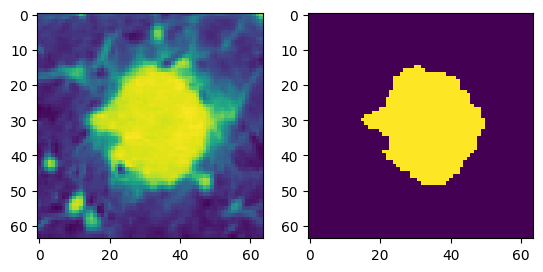

In [43]:
slc = 8
fig, ax = plt.subplots(1, 2)
ax[0].imshow(pred[0, 0, slc, :, :].detach().numpy())
ax[1].imshow(mask[0, 0, slc, :, :].detach().numpy())